In [3]:
"""
By Gideon Kassa
Oct 16, 2024

Wef
Dartmouth College
"""

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import sympy as sp

In [72]:
with open('CZP_pSiO2_R_T_A.txt', 'r+') as f:
    full_file = f.read()

Eg, reflection, transmission, A = np.array([i.split('\t') for i in full_file.split('\n')], dtype=np.float32).T

wavelengths = 1240/Eg  # nm
transmission /= 100  # 0 to 1
reflection /= 100  # 0 to 1
thickness = 460  # nm

In [45]:
# if we have 4 materials (air, film, substrate, air)
n1, k1, n2, k2, n3, k3, n4, k4, d1, d2, d3, d4, wl, R = sp.symbols('n1 k1 n2 k2 n3 k3 n4 k4 d1 d2 d3 d4 wl, R')

# assume air is semi infinite
beta_2 = 2 * np.pi * d2 / wl
beta_3 = 2 * np.pi * d3 / wl

# the complex refractive index...
n_k1 = n1 + 1j * k1
n_k2 = n2 + 1j * k2
n_k3 = n3 + 1j * k3
n_k4 = n4 + 1j * k4

# air/film interface
M_I1 = (1/(2*n_k1/(n_k1+n_k2)))* sp.Matrix([[1, (n_k1 - n_k2)/(n_k1 + n_k2)],
                                            [(n_k1 - n_k2)/(n_k1 + n_k2), 1]])

# film propagation
M_P1 = sp.Matrix(
    [[sp.exp(-1j * n_k2 * beta_2), 0],
     [0, sp.exp(1j * n_k2 * beta_2)]
])

# film/substrate interface
M_I2 = (1/(2*n_k2/(n_k2+n_k3)))* sp.Matrix([[1, (n_k2 - n_k3)/(n_k2 + n_k3)],
                                            [(n_k2 - n_k3)/(n_k2 + n_k3), 1]])

# substrate propagation
M_P2 = sp.Matrix(
    [[sp.exp(-1j * n_k3 * beta_3), 0],
     [0, sp.exp(1j * n_k3 * beta_3)]])

# substrate/air interface
M_I3 = (1/(2*n_k3/(n_k3+n_k1)))* sp.Matrix([[1, (n_k3 - n_k1)/(n_k3 + n_k1)],
                                            [(n_k3 - n_k1)/(n_k3 + n_k1), 1]])

# assemble
M = M_I1 * M_P1 * M_I2 * M_P2 * M_I3

T = abs(1/M[0, 0])**2
R = abs(M[1, 0]/M[0, 0])**2

T = sp.lambdify([n1, k1, n2, k2, n3, k3, n4, k4, d1, d2, d3, d4, wl], T)
R = sp.lambdify([n1, k1, n2, k2, n3, k3, n4, k4, d1, d2, d3, d4, wl], R)

wl = 500

n1 = 1
k1 = 0

n2 = 3.66769
k2 = 0.27805

n3 = 1.46
k3 = 0

n4 = 1
k4 = 0

d1 = 0
d2 = 470
d3 = 1e6
d4 = 0


print(f"transmission = {T(n1, k1, n2, k2, n3, k3, n4, k4, d1, d2, d3, d4, wl)}")
print(f"reflection = {R(n1, k1, n2, k2, n3, k3, n4, k4, d1, d2, d3, d4, wl)}")

transmission = 0.017796841439349776
reflection = 0.32255382122133597


In [ ]:
# takes a long time to compute so lets select a wl range to look at...

start = 400 # wl to start at
end = 500
wl_range = abs(start-end)

d_film = thickness
n_air = 1
k_air = 0
k_subs = 0
d_subs = 0 # cause were assuming no propagation loss from the substrate, this makes the calc faster :)

def objective(x, wavelength, measured_R, measured_T):
    error = 0
    n = x[:wl_range]
    k = x[wl_range:]

    for n_i, k_i, wl_i, r_i, t_i in zip(n, k, wavelength, measured_R, measured_T):

        # the refractive index of the SiO2 substrate calculated for each wl
        n_subs = (1+0.9310/(1-(0.079/(wl_i/1000))**2)+0.1735/(1-(0.130/(wl_i/1000))**2)+2.1121/(1-(14.918/(wl_i/1000))**2))**0.5

        R_calc = R(n_air, k_air, n_i, k_i, n_subs, k_subs, n_air, k_air, 0, d_film, d_subs, 0, wl_i)
        T_calc = T(n_air, k_air, n_i, k_i, n_subs, k_subs, n_air, k_air, 0, d_film, d_subs, 0, wl_i)

        error += ((T_calc - t_i)**2 + (R_calc - r_i)**2)

    return error

n_init = np.ones(wl_range) + 1
k_init = np.zeros(wl_range) + 0.5

popt = minimize(objective, np.concatenate((n_init, k_init)), args=(wavelengths[start:end], reflection[start:end], transmission[start:end]))

n = popt.x[:wl_range]
k = popt.x[wl_range:]

plt.plot(n)
plt.plot(k)

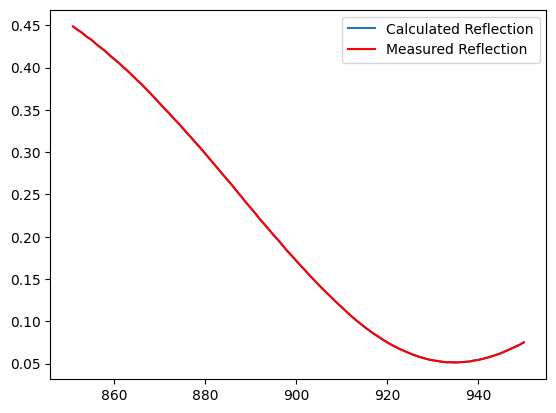

In [85]:
ts = []
rs = []

for ns, ks, wl in zip(n, k, wavelengths[start:end]):

    ts.append(T(n_air, k_air, ns, ks, 1.4, k_subs, n_air, k_air, 0, thickness, d_subs, 0, wl))
    rs.append(R(n_air, k_air, ns, ks, 1.4, k_subs, n_air, k_air, 0, thickness, d_subs, 0, wl))

plt.plot(wavelengths[start:end], rs, label='Calculated Reflection')
plt.plot(wavelengths[start:end], reflection[start:end], 'r-', label='Measured Reflection')
plt.legend()

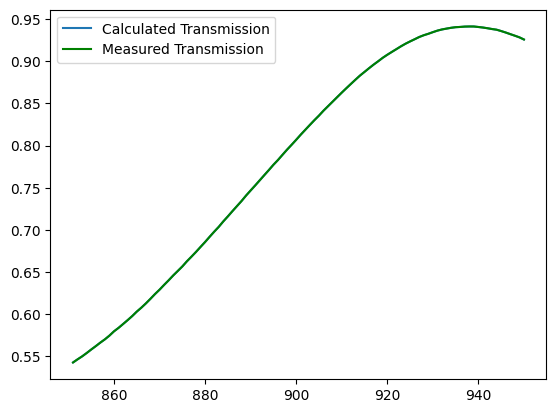

In [86]:
plt.plot(wavelengths[start:end], ts, label='Calculated Transmission')
plt.plot(wavelengths[start:end], transmission[start:end], 'g-', label='Measured Transmission')
plt.legend()